#**Beijing Air Quality Forecasting Starter Notebook**

In [77]:
# Import necessary libraries
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [ ]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##**Data Preprocessing**

In [50]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
train = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/test.csv')

## **Explore the training data**

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [51]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [62]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [66]:
# Convert 'datetime' to datetime and set as index
train['datetime'] = pd.to_datetime(train['datetime'])
train.set_index('datetime', inplace=True)
test['datetime'] = pd.to_datetime(test['datetime'])
test.set_index('datetime', inplace=True)

In [67]:
# Extract time features
for df in [train, test]:
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year

In [30]:
# Ensure 'datetime' column is in datetime format
# train['datetime'] = pd.to_datetime(train['datetime'])

# test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
# train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
# test.set_index('datetime', inplace=True)

##**Handle missing values**
Check the dataset for missing values and decide how to handle them.
In this example, missing values are filled with the mean. You can experiment with other strategies.

In [68]:
# Handle missing values using TRAINING data's mean
train_mean = train.mean()
train.fillna(train_mean, inplace=True)
test.fillna(train_mean, inplace=True)

##**Separate features and target**
Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [69]:
# Prepare features and target
X = train.drop(['pm2.5', 'No'], axis=1)
y = train['pm2.5']
X_test = test.drop('No', axis=1)

In [70]:
# Split into train and validation (NO SHUFFLING)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

In [71]:
# Scale data using training statistics
scaler_X = MinMaxScaler().fit(X_train)
scaler_y = MinMaxScaler().fit(y_train.values.reshape(-1, 1))

X_train_scaled = scaler_X.transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))

# Reshape for LSTM (samples, timesteps, features)
def reshape_data(data):
    return data.reshape((data.shape[0], 1, data.shape[1]))

X_train_reshaped = reshape_data(X_train_scaled)
X_val_reshaped = reshape_data(X_val_scaled)
X_test_reshaped = reshape_data(X_test_scaled)

In [ ]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
# X_train = np.expand_dims(X_train, axis=1)

##**Build model**
Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [72]:
# Build LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dropout(0.4),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [73]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(
    X_train_reshaped, y_train_scaled,
    validation_data=(X_val_reshaped, y_val_scaled),
    epochs=150,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/150
767/767 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 0.0075 - mae: 0.0620 - val_loss: 0.0084 - val_mae: 0.0598 - learning_rate: 0.0010
Epoch 2/150
767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0058 - mae: 0.0534 - val_loss: 0.0098 - val_mae: 0.0618 - learning_rate: 0.0010
Epoch 3/150
767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0055 - mae: 0.0524 - val_loss: 0.0075 - val_mae: 0.0594 - learning_rate: 0.0010
Epoch 4/150
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0055 - mae: 0.0517 - val_loss: 0.0072 - val_mae: 0.0573 - learning_rate: 0.0010
Epoch 5/150
767/767 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0053 - mae: 0.0509 - val_loss: 0.0074 - val_mae: 0.0579 - learning_rate: 0.0010
Epoch 6/150
767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0052 - mae: 0.0506 - val_loss: 0.0081 - val_mae: 0.0580 - learning_rate: 0.0010
Epoch 7/150
767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0052 - mae: 0.0503 - val_loss: 0.0077 - val_mae: 0.0578 - learning_rate: 0

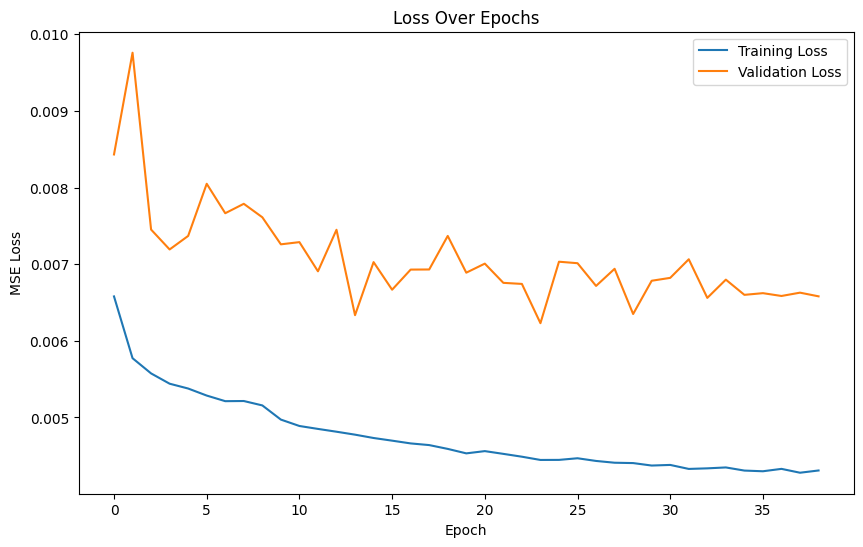

In [74]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [76]:
# Predict on the test data
predictions = model.predict(X_test_reshaped)

# Inverse transform predictions to original scale
predictions = scaler_y.inverse_transform(predictions)

# Prepare submission with proper formatting
submission = pd.DataFrame({
    'row ID': test.index.strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': predictions.flatten()
})

# Sort by row ID to ensure chronological order
submission = submission.sort_values('row ID')

# Save submission
save_path = "/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/"
submission.to_csv(save_path + "subm15_fixed_final.csv", index=False)
print("Submission file formatted and saved!")

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Submission file formatted and saved!
